In [9]:
import keras
import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

#Importing the VAE and RNN.
import os
import sys
#Adding WorldModels path to pythonpath
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

/home/kaiolae/code/word_models_keras_test/WorldModels


In [10]:

import analyze_rnn_predictions
%load_ext autoreload
%autoreload 2 #If we want to automatically load external modules as they are updated.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#To access gym
import sys
sys.path.append('/home/kaiolae/.virtualenvs/worldmodels/lib/python3.5/site-packages')
import os

In [12]:
import fnmatch
def get_all_models():
    all_models = {} #Dict of all models, with num mixtures as key
    for folder in os.listdir('../'):
        
        if fnmatch.fnmatch(folder, 'trained_sequential_rnn_*') :
            mixtures_start_index = folder.find('rnn_')+4
            mixtures_end_index = folder.find('mixtures')
            num_mixtures = int(folder[mixtures_start_index:mixtures_end_index])
            if num_mixtures in all_models.keys():
                all_models[num_mixtures].append("../"+folder)
            else:
                all_models[num_mixtures] = ["../"+folder]
            
    return all_models
            
print(get_all_models())

{1: ['../trained_sequential_rnn_1mixtures_run10', '../trained_sequential_rnn_1mixtures_run5', '../trained_sequential_rnn_1mixtures_run2', '../trained_sequential_rnn_1mixtures_run7', '../trained_sequential_rnn_1mixtures_run11', '../trained_sequential_rnn_1mixtures_run13', '../trained_sequential_rnn_1mixtures_run9', '../trained_sequential_rnn_1mixtures_run1', '../trained_sequential_rnn_1mixtures_run14', '../trained_sequential_rnn_1mixtures_run6', '../trained_sequential_rnn_1mixtures_run3', '../trained_sequential_rnn_1mixtures_run12', '../trained_sequential_rnn_1mixtures_run8', '../trained_sequential_rnn_1mixtures_run4'], 2: ['../trained_sequential_rnn_2mixtures_run12', '../trained_sequential_rnn_2mixtures_run3', '../trained_sequential_rnn_2mixtures_run11', '../trained_sequential_rnn_2mixtures_run13', '../trained_sequential_rnn_2mixtures_run7', '../trained_sequential_rnn_2mixtures_run8', '../trained_sequential_rnn_2mixtures_run2', '../trained_sequential_rnn_2mixtures_run14', '../trained_s

In [13]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML


def plot_movie_mp4(image_array):
    dpi = 2.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    #fig = plt.figure(figsize=(1,1), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [14]:
from collections import namedtuple

rnn_analyzers = {}
filename = "rnn_trained_model.h5"
for key, val in get_all_models().items():
    rnn_analyzers[key] = []
    for model in val:
        if filename not in os.listdir(model):
            print("Unfinished run. Skipping.")
            continue
        print("Loading model: ", model)
        new_analyzer = analyze_rnn_predictions.RNNAnalyzer(model+"/"+filename, key, 0.2) #TODO Note, I previously used temp=0.1 - Which Ha noted was so low that we got mode collapse.
        rnn_analyzers[key].append(new_analyzer)
        break #Just getting 1 model per parameter setting
print("rnn analyzers: ", rnn_analyzers)

Unfinished run. Skipping.
Unfinished run. Skipping.
Loading model:  ../trained_sequential_rnn_1mixtures_run2
VAE init
Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 64, 64, 3)    39          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 32)   416         conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Co

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_LSTM (LSTM)            (1, 256)                  329728    
_________________________________________________________________
decoder_output_MDN (MDN)     (1, 1032)                 265224    
Total params: 594,952
Trainable params: 594,952
Non-trainable params: 0
_________________________________________________________________
Loading model:  ../trained_sequential_rnn_4mixtures_run9
VAE init
Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
____________________________________________________________________________________________

In [23]:
def fetch_random_observations_sequence(min_length = 100):
    fetched_data = False
    episode_num = random.randint(0,200)
    while not fetched_data:
        action_sequence = action_data[episode_num]
        latent_sequence = observation_data[episode_num]
        num_frames = len(latent_sequence)
        if num_frames >= 150:
            fetched_data=True
        else:
            episode_num = random.randint(0,200)
    return latent_sequence, action_sequence

In [24]:
#Get a start video
#Getting data to feed into the VAE and RNN
import numpy as np
import os
import random
# load preprocessed data
training_data = np.load(os.path.join("../rnn_data_64_dim", "rnn_training_data.npz"))
action_data = training_data['action']
observation_data = training_data['latent']

single_latent_sequence, single_action_sequence = fetch_random_observations_sequence(150)



#Decode all 100 vectors, store as video
#Visualize video.

In [16]:
#Decode a sequence with the VAE and visualize it
def decode_and_visualize(latent_vector_sequence, rnn_analyzer):
    plot_movie_mp4(rnn_analyzer.decode_with_vae(latent_vector_sequence))

In [25]:
def calc_mixture_weights_and_events_dreaming(rnn_analyzer, dream_steps=100):
    latent_sequence, action_sequence = fetch_random_observations_sequence(101)
    #Analyzing a single model
    WARM_UP_STEPS = 100
    previous_z = latent_sequence[WARM_UP_STEPS]

    mixture_weight_history = []
    z_history = []
    rnn_analyzer._reset()
    rnn_analyzer.warm_up_lstm(action_sequence, latent_sequence)
    for i in range(dream_steps):
        previous_z, mixture_weights = rnn_analyzer.predict_one_step(0, previous_z)
        z_history.append(previous_z)
        mixture_weight_history.append(mixture_weights)
    return np.array(mixture_weight_history), np.array(z_history)

In [18]:
def visualize_mixture_weights_and_events(weights_sequence, z_sequence, rnn_analyzer):
    plt.plot(weights_sequence)
    plt.figure(figsize=(20,10))
    columns = 4
    counter = 0
    skip_image = 5
    decoded_images = rnn_analyzer.decode_with_vae(z_sequence)
    plot_counter = 0
    for d in decoded_images:
        if counter%skip_image == 0:
            if plot_counter%columns == 0:
                print("Timestep: ", counter)
            plt.subplot((len(z_sequence)//skip_image)//columns + 1, columns, plot_counter+1)
            plt.imshow(d)
            plot_counter+=1
        counter+=1

zs are  [[-1.26410926  0.22472084 -0.08732585 ... -0.06337782 -0.21241811
   0.20177759]
 [-0.87544099  0.05045622  0.14618975 ...  0.03676023 -0.31041941
  -0.07939689]
 [-0.95699151  0.20008432  0.21788223 ...  0.03165416  0.16098059
  -0.20356448]
 ...
 [ 1.75122091  0.60391377 -0.55821044 ...  0.37941729  1.94451298
  -0.66214685]
 [ 0.40516789 -0.11043251 -0.76105044 ...  0.0158375   1.82015614
  -1.05222815]
 [ 0.62332022 -0.06245083  0.03911706 ...  1.89812057 -0.00640234
  -0.64540707]]
Timestep:  0
Timestep:  20
Timestep:  40
Timestep:  60
Timestep:  80


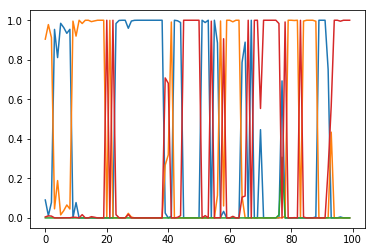

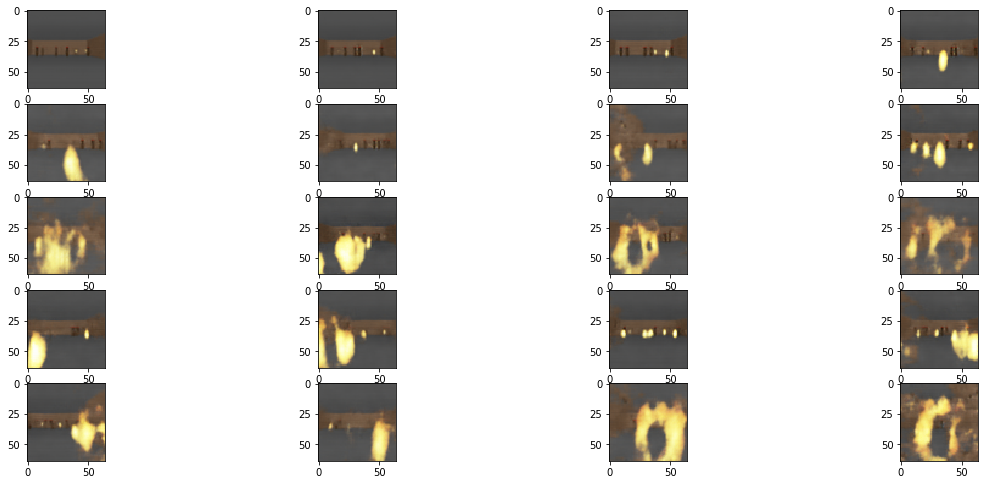

In [20]:
analyzer1= rnn_analyzers[4][0]
weights, zs = calc_mixture_weights_and_events_dreaming(analyzer1)
print("zs are ", zs)
visualize_mixture_weights_and_events(weights, zs, analyzer1)


In [64]:
new_analyzer = analyze_rnn_predictions.RNNAnalyzer("../trained_sequential_rnn_4mixtures_run9/rnn_trained_model.h5", 4, 0.01)
weights, zs = calc_mixture_weights_and_events_dreaming(new_analyzer)
decoded_images = new_analyzer.decode_with_vae(zs)
plot_movie_mp4(decoded_images)

VAE init
Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 64, 64, 3)    39          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 32, 32, 32)   416         conv2d_205[0][0]                 
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 16, 16, 32)   4128        conv2d_206[0][0]                 
_______________________

<Figure size 64x64 with 0 Axes>

In [32]:
import count_monsters_and_balls
import numpy as np
import collections
FIREBALL_THRESHOLD = 0.5
WALL_THRESHOLD = 0.39

def count_appearances_of_most_common_element_in_array(array):
    array=np.array(array)
    c = collections.Counter(array)
    m_c = c.most_common()
    print(m_c)
    if len(m_c)==0:
        return 0
    return m_c[0][1]

def name_most_common_element_in_array(array):
    array=np.array(array)
    c = collections.Counter(array)
    m_c = c.most_common()
    print(m_c)
    if len(m_c)==0:
        return 0
    return m_c[0][0]

import pandas as pd

#Based on a dream, generates a dict indexed by mixture ID (e.g. 1-4) where each mixture has 
#a list of events, and how many of those it generated. Example:
#{"m1": {"explode": 4, "wall: 5"}, "m2": {"explode": 1, "wall": 22}}
def count_events_in_each_mixture(analyzer, num_mixtures, num_steps = 100):
    weights, zs = calc_mixture_weights_and_events_dreaming(analyzer,num_steps)
    decoded_images = analyzer.decode_with_vae(zs)
    visualize_mixture_weights_and_events(weights, zs, analyzer)
    mixtures_events_counter={}    
    
    for num in range(num_mixtures):
        mixtures_events_counter[num] = {"mixture_num" : num, "explosion":0, "fireball": 0, "left_wall": 0, "right_wall": 0, "other": 0}
    for img_counter in range(len(decoded_images)):
        img = decoded_images[img_counter]
        weight_vector = weights[img_counter]
        dominating_mixture = np.argmax(weight_vector)
        is_exploding = count_monsters_and_balls.is_there_a_big_explosion(img, FIREBALL_THRESHOLD)
        is_fireball, _ = count_monsters_and_balls.count_fireballs(img, FIREBALL_THRESHOLD)
        is_left_wall = count_monsters_and_balls.is_there_a_lefthand_wall(img, WALL_THRESHOLD)
        is_right_wall = count_monsters_and_balls.is_there_a_righthand_wall(img, WALL_THRESHOLD)

        if is_exploding:
            mixtures_events_counter[dominating_mixture]["explosion"] += 1
        elif is_fireball:
            mixtures_events_counter[dominating_mixture]["fireball"] += 1
        elif is_left_wall:
            mixtures_events_counter[dominating_mixture]["left_wall"] += 1
        elif is_right_wall:
            mixtures_events_counter[dominating_mixture]["right_wall"] += 1
        else:
            mixtures_events_counter[dominating_mixture]["other"] += 1

    return mixtures_events_counter
               

Timestep:  0
Timestep:  20
Timestep:  40
Timestep:  60
Timestep:  80
Timestep:  100
Timestep:  120
Timestep:  140
Timestep:  160
Timestep:  180
Timestep:  200
Timestep:  220
Timestep:  240
Timestep:  260
Timestep:  280
Timestep:  300
Timestep:  320
Timestep:  340
Timestep:  360
Timestep:  380
Timestep:  400
Timestep:  420
Timestep:  440
Timestep:  460
Timestep:  480
Timestep:  500
Timestep:  520
Timestep:  540
Timestep:  560
Timestep:  580
Timestep:  600
Timestep:  620
Timestep:  640
Timestep:  660
Timestep:  680
Timestep:  700
Timestep:  720
Timestep:  740
Timestep:  760
Timestep:  780
Timestep:  800
Timestep:  820
Timestep:  840
Timestep:  860
Timestep:  880
Timestep:  900
Timestep:  920
Timestep:  940
Timestep:  960
Timestep:  980
Timestep:  0
Timestep:  20
Timestep:  40
Timestep:  60
Timestep:  80
Timestep:  100
Timestep:  120
Timestep:  140
Timestep:  160
Timestep:  180
Timestep:  200
Timestep:  220
Timestep:  240
Timestep:  260
Timestep:  280
Timestep:  300
Timestep:  320
Timeste

Timestep:  180
Timestep:  200
Timestep:  220
Timestep:  240
Timestep:  260
Timestep:  280
Timestep:  300
Timestep:  320
Timestep:  340
Timestep:  360
Timestep:  380
Timestep:  400
Timestep:  420
Timestep:  440
Timestep:  460
Timestep:  480
Timestep:  500
Timestep:  520
Timestep:  540
Timestep:  560
Timestep:  580
Timestep:  600
Timestep:  620
Timestep:  640
Timestep:  660
Timestep:  680
Timestep:  700
Timestep:  720
Timestep:  740
Timestep:  760
Timestep:  780
Timestep:  800
Timestep:  820
Timestep:  840
Timestep:  860
Timestep:  880
Timestep:  900
Timestep:  920
Timestep:  940
Timestep:  960
Timestep:  980
Timestep:  0
Timestep:  20
Timestep:  40
Timestep:  60
Timestep:  80
Timestep:  100
Timestep:  120
Timestep:  140
Timestep:  160
Timestep:  180
Timestep:  200
Timestep:  220
Timestep:  240
Timestep:  260
Timestep:  280
Timestep:  300
Timestep:  320
Timestep:  340
Timestep:  360
Timestep:  380
Timestep:  400
Timestep:  420
Timestep:  440
Timestep:  460
Timestep:  480
Timestep:  500
T

/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Timestep:  0
Timestep:  20
Timestep:  40
Timestep:  60
Timestep:  80
Timestep:  100
Timestep:  120
Timestep:  140
Timestep:  160
Timestep:  180
Timestep:  200
Timestep:  220
Timestep:  240
Timestep:  260
Timestep:  280
Timestep:  300
Timestep:  320
Timestep:  340
Timestep:  360
Timestep:  380
Timestep:  400
Timestep:  420
Timestep:  440
Timestep:  460
Timestep:  480
Timestep:  500
Timestep:  520
Timestep:  540
Timestep:  560
Timestep:  580
Timestep:  600
Timestep:  620
Timestep:  640
Timestep:  660
Timestep:  680
Timestep:  700
Timestep:  720
Timestep:  740
Timestep:  760
Timestep:  780
Timestep:  800
Timestep:  820
Timestep:  840
Timestep:  860
Timestep:  880
Timestep:  900
Timestep:  920
Timestep:  940
Timestep:  960
Timestep:  980
                                                    0  \
0   {'mixture_num': 0, 'explosion': 47, 'fireball'...   
1   {'mixture_num': 0, 'explosion': 0, 'fireball':...   
2   {'mixture_num': 0, 'explosion': 32, 'fireball'...   
3   {'mixture_num': 0, 'expl

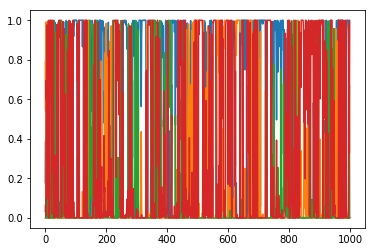

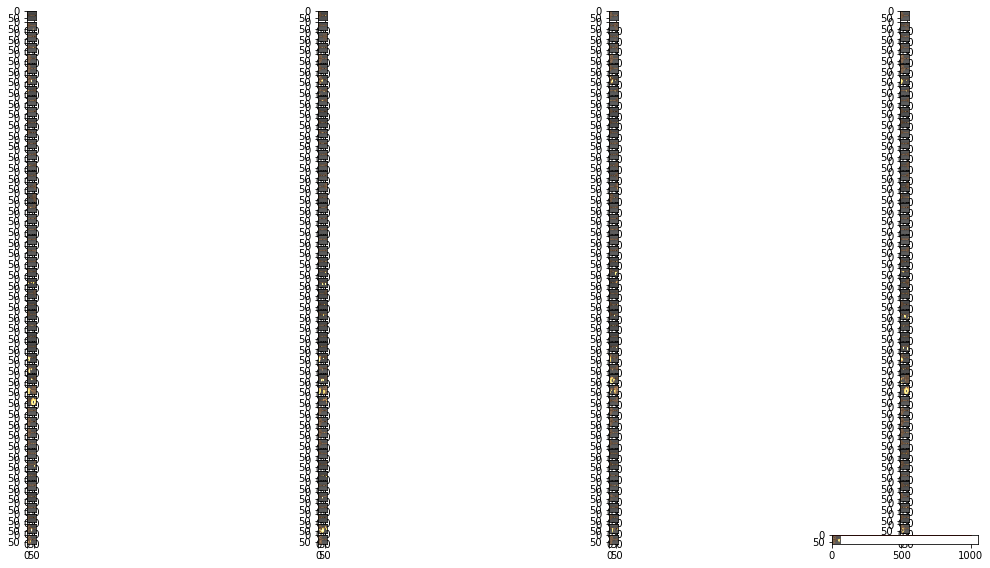

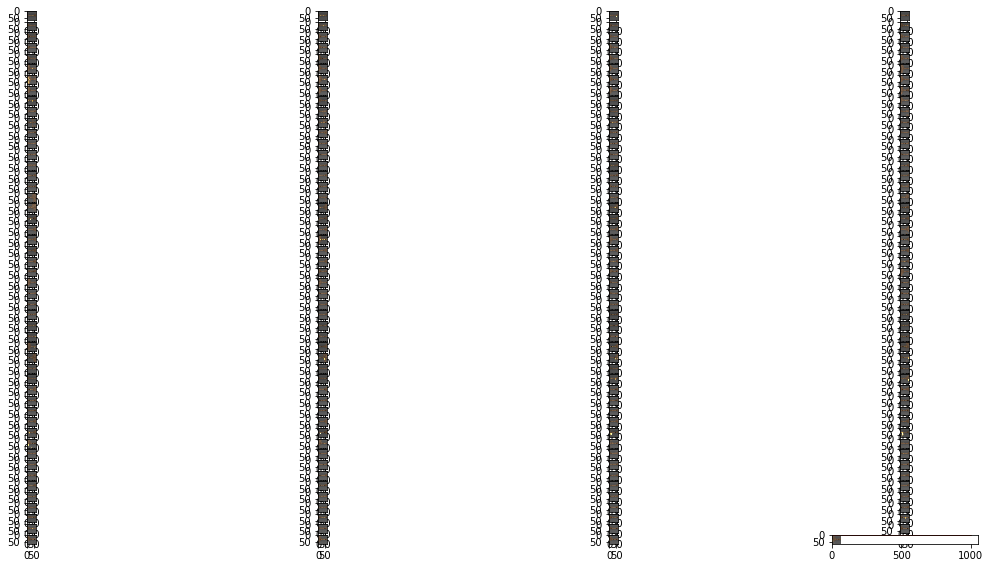

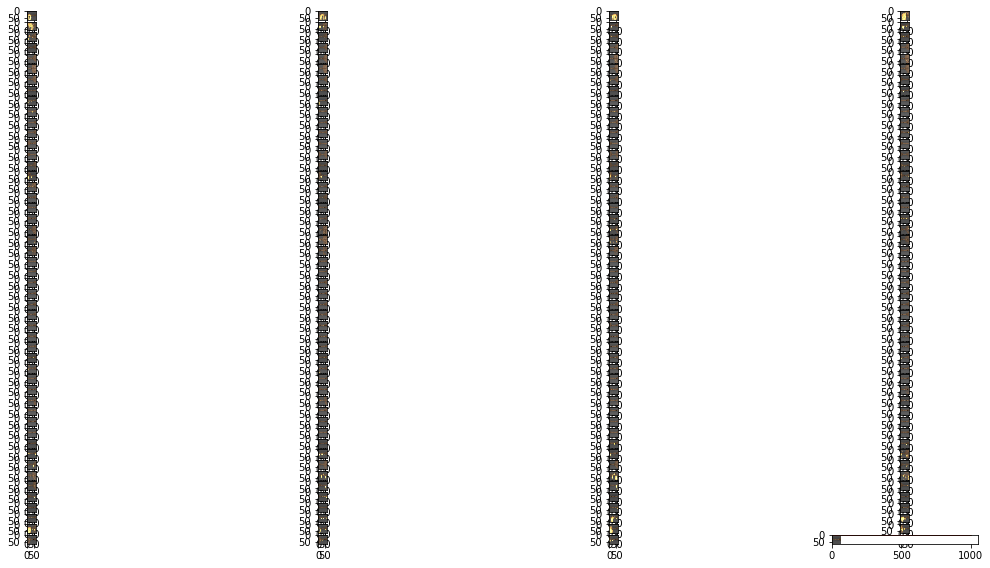

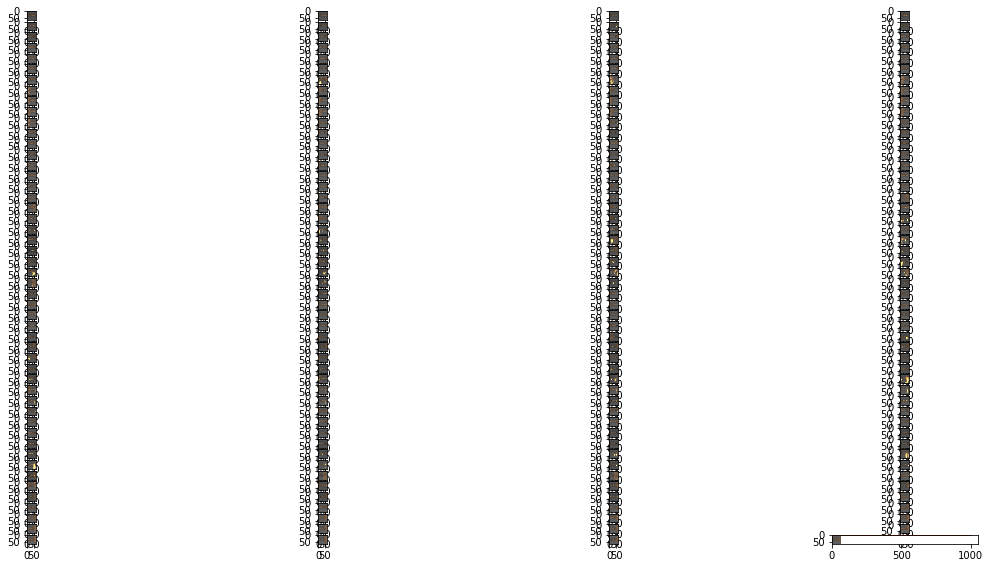

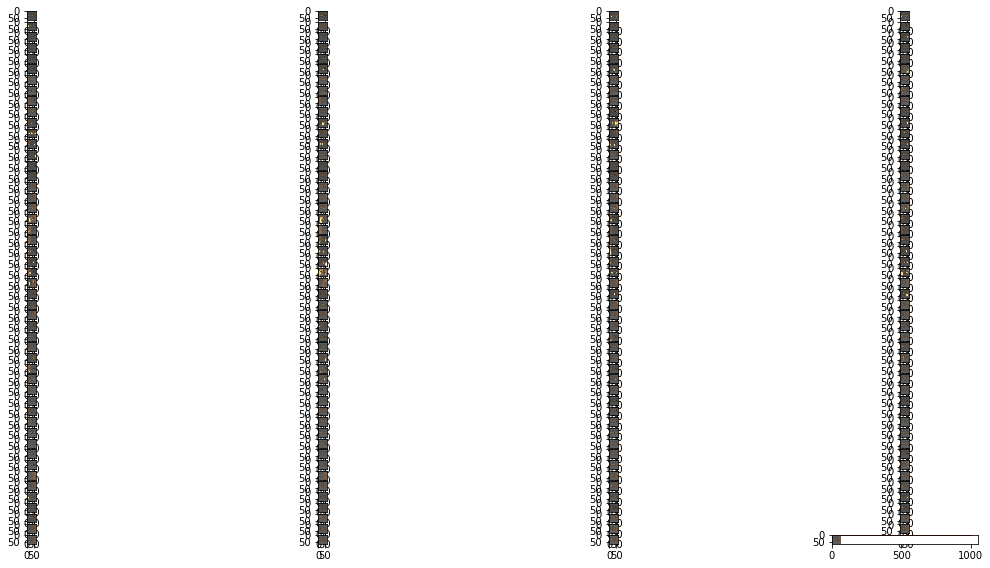

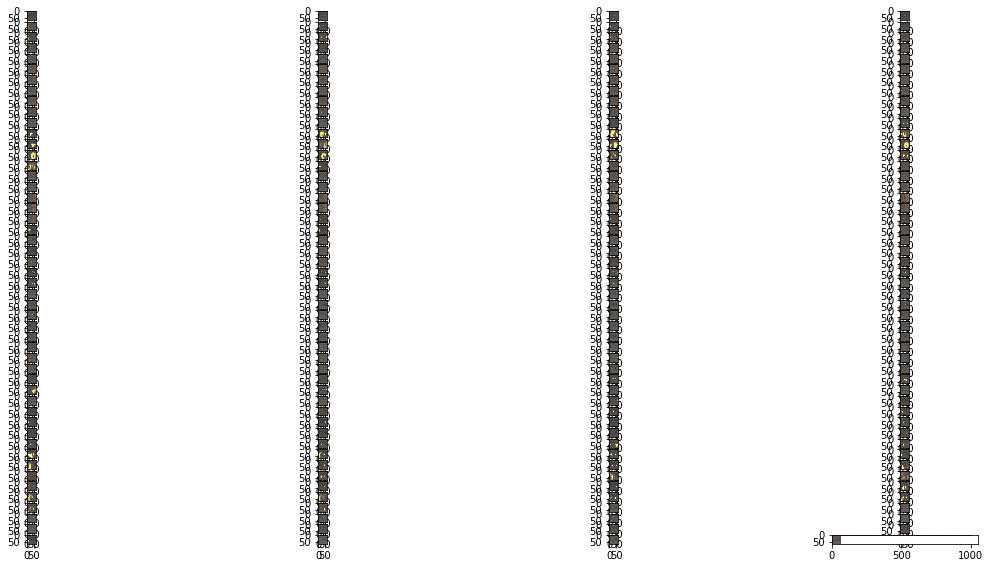

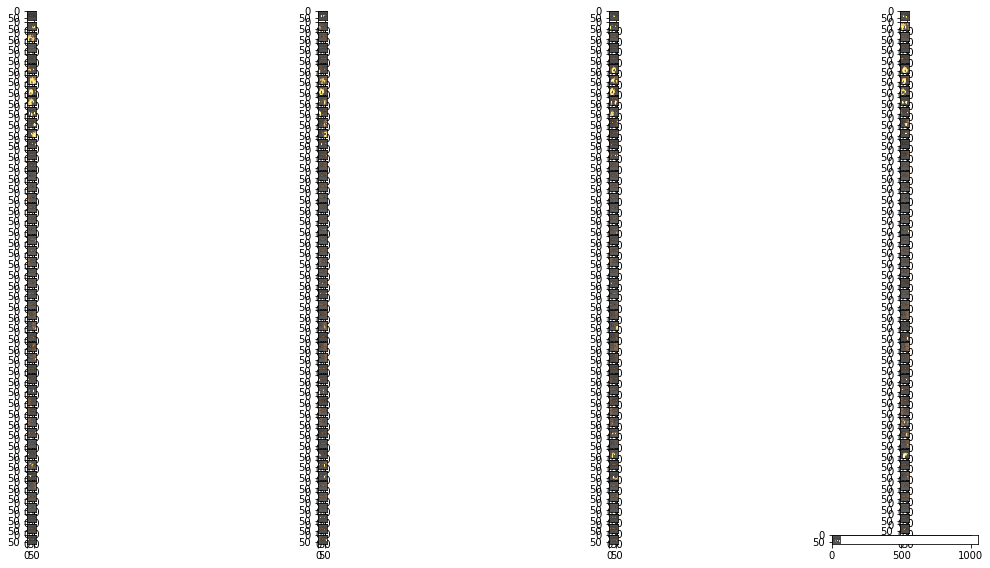

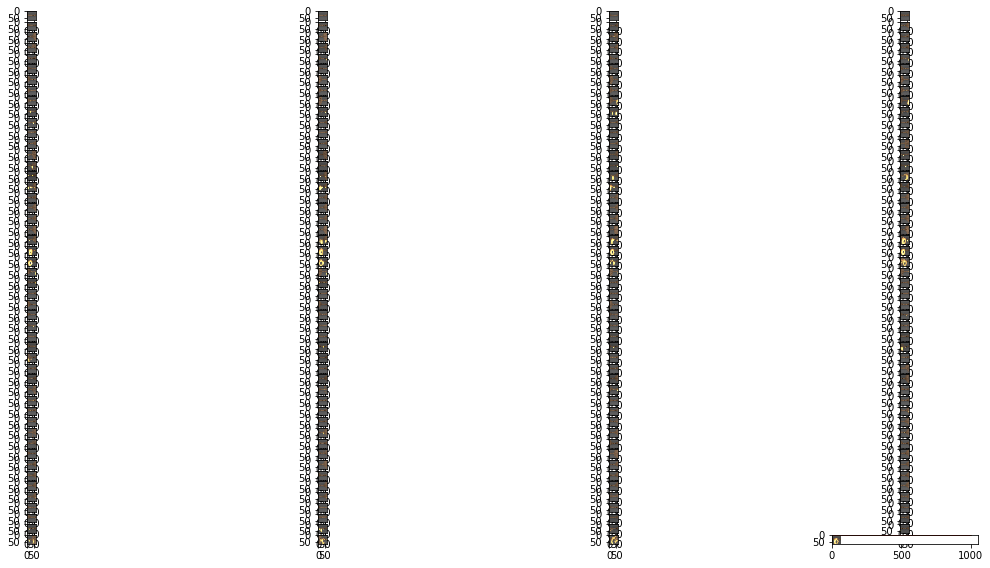

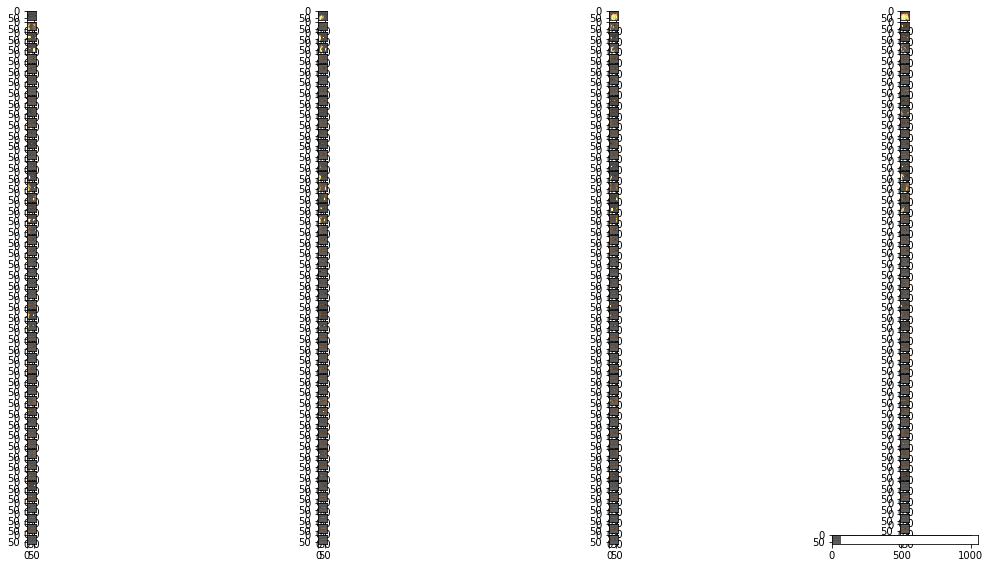

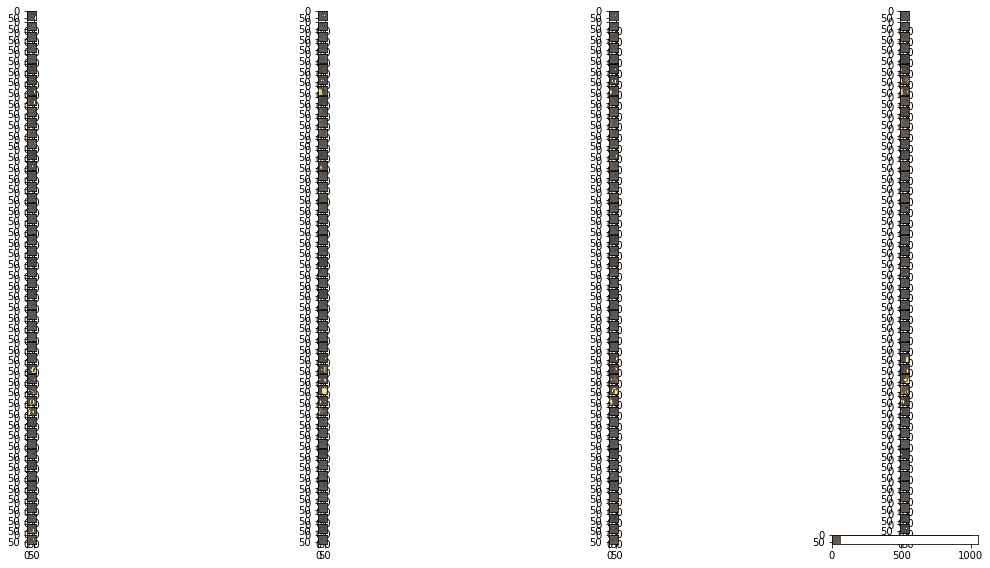

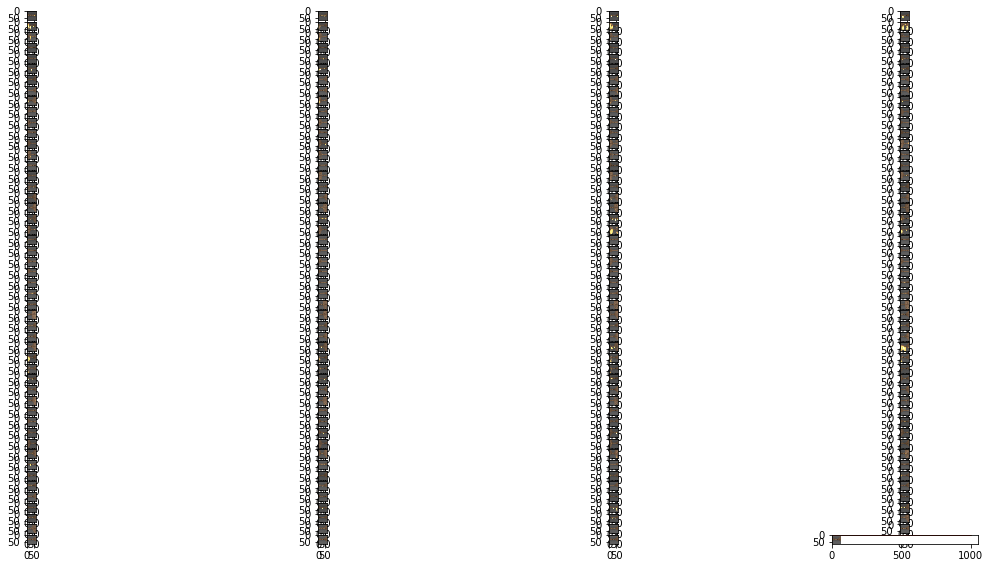

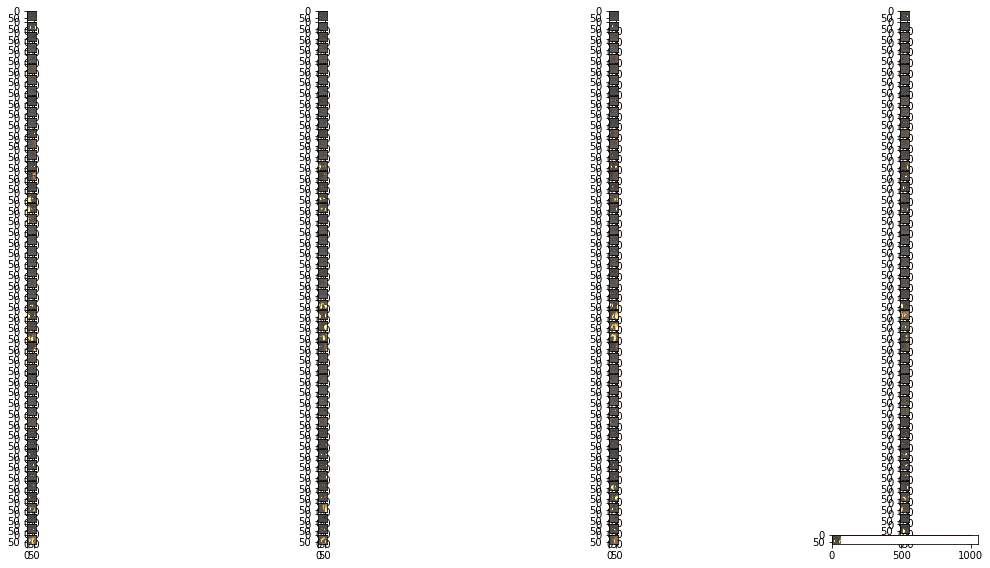

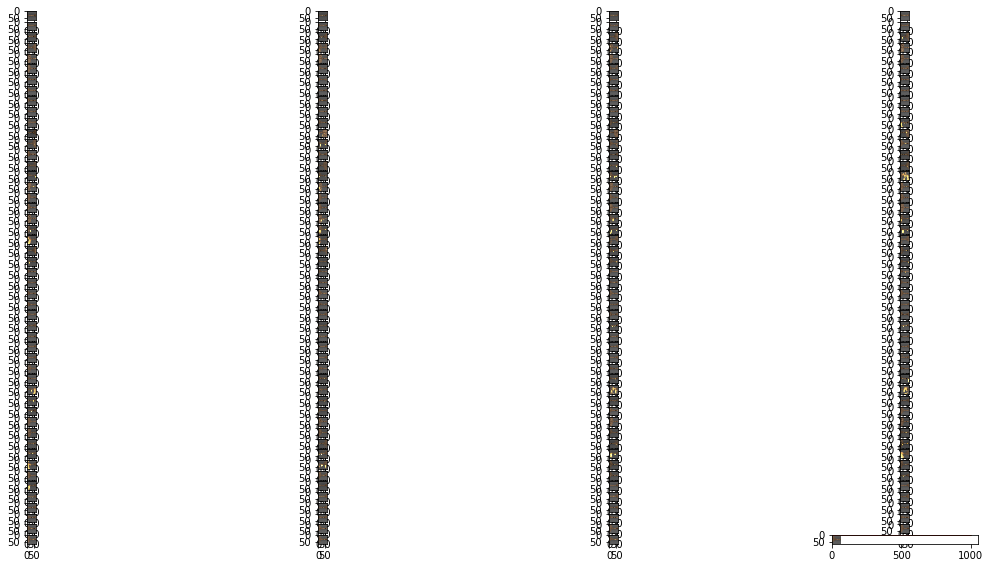

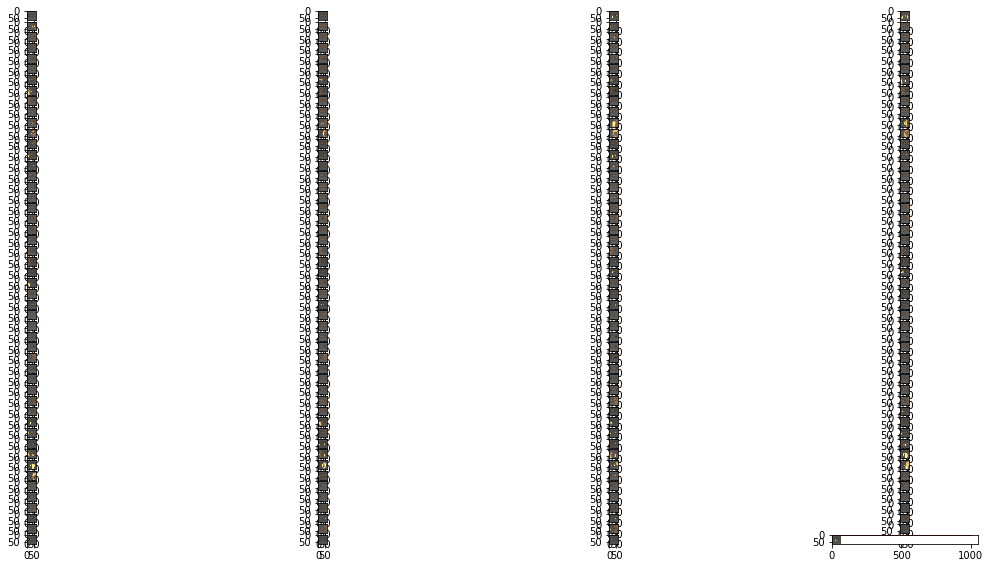

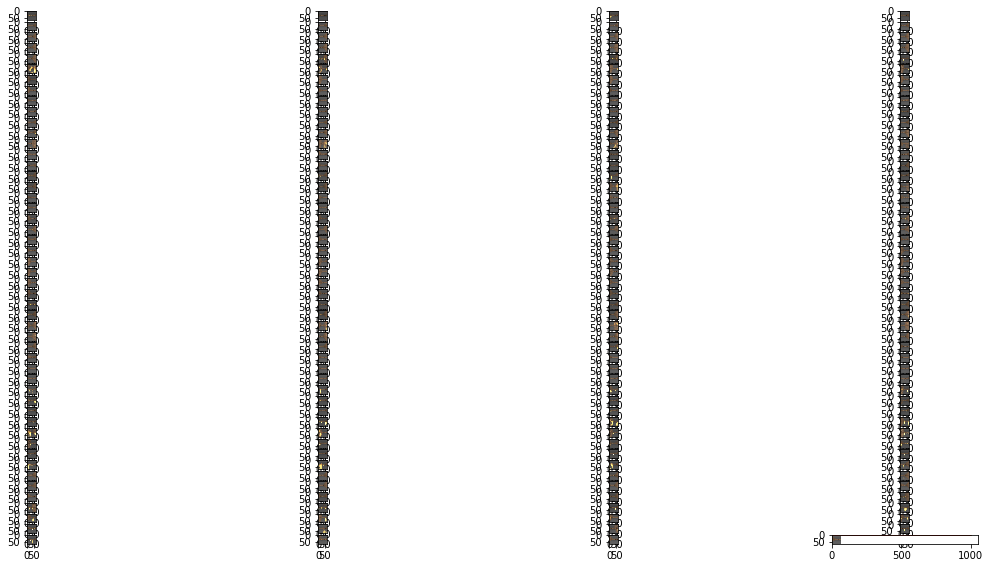

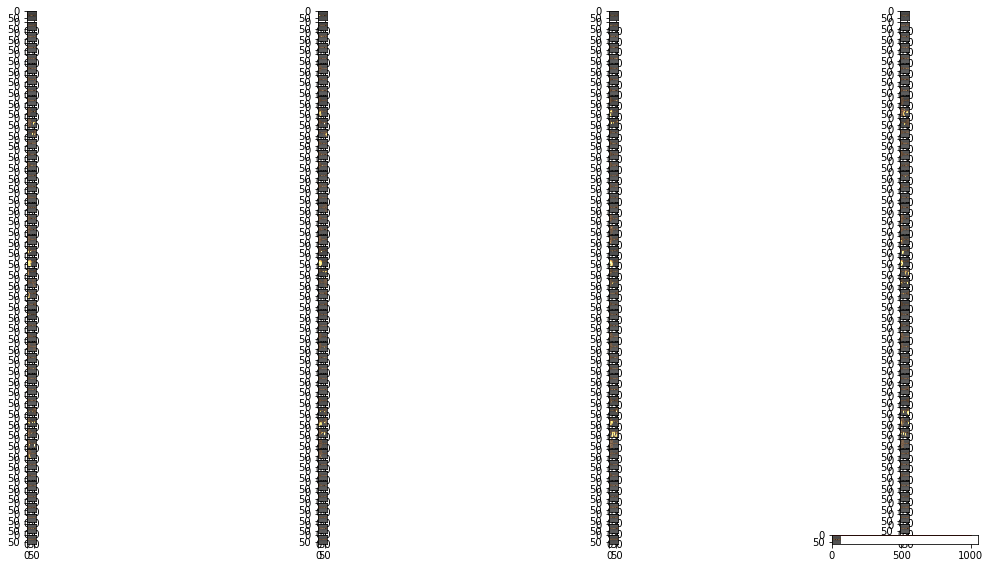

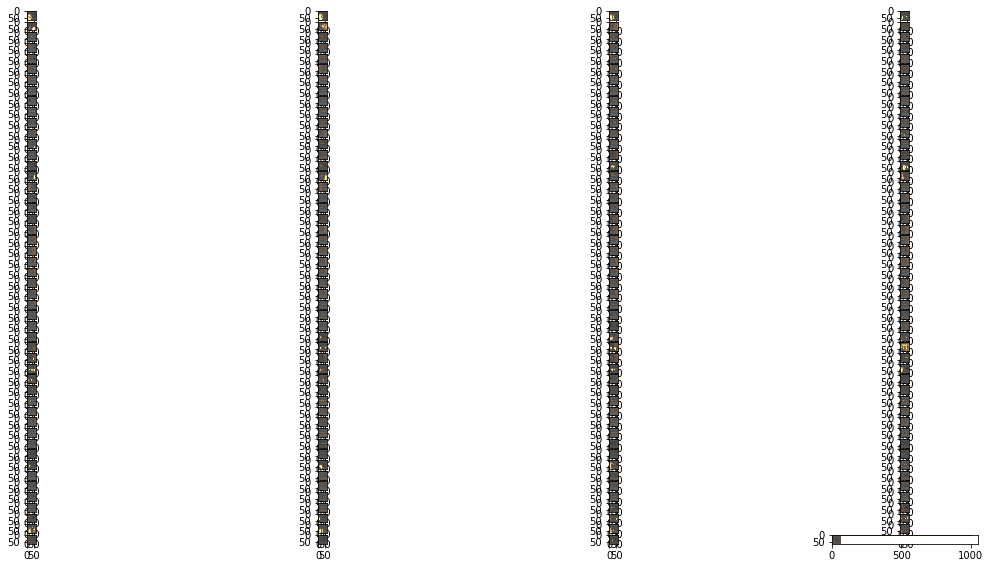

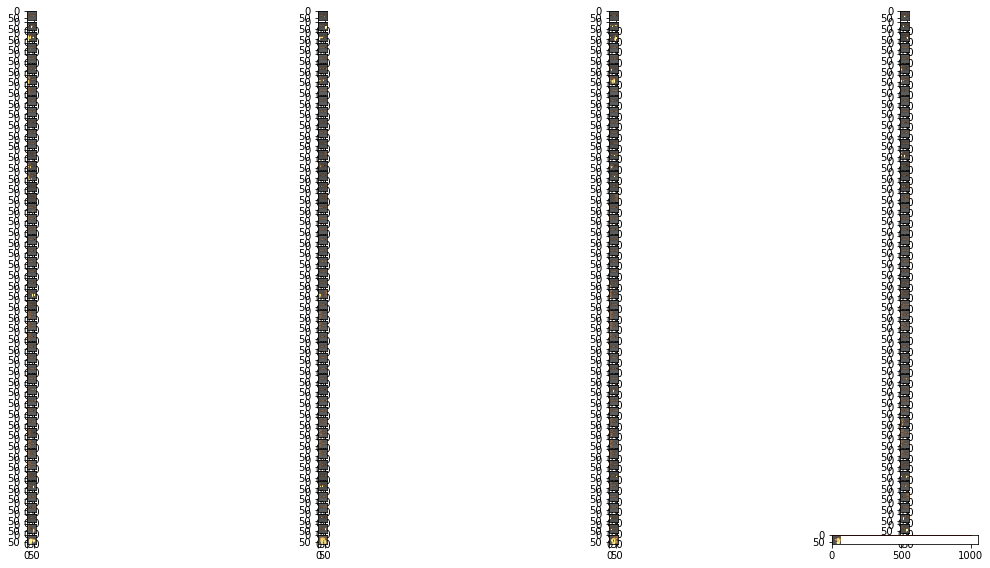

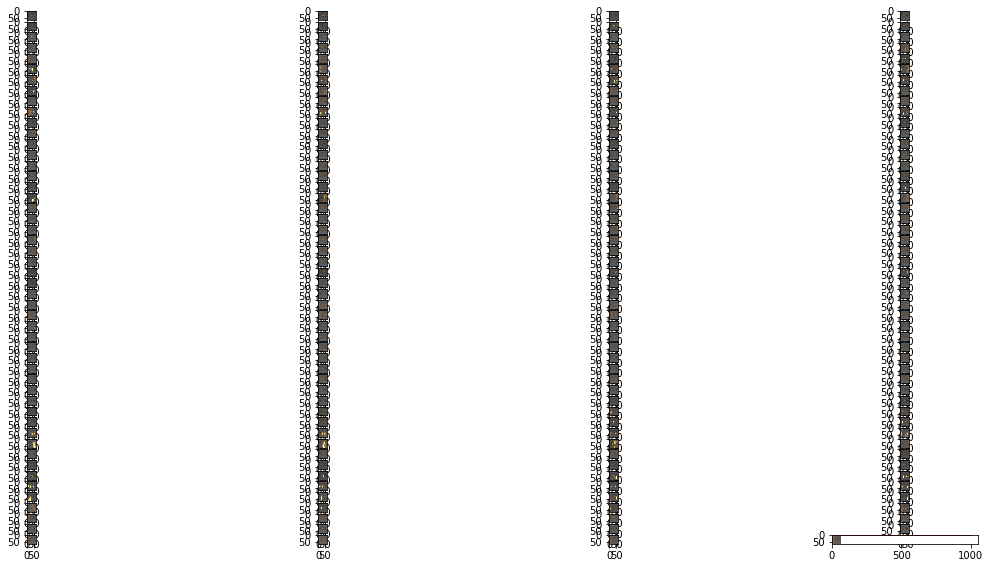

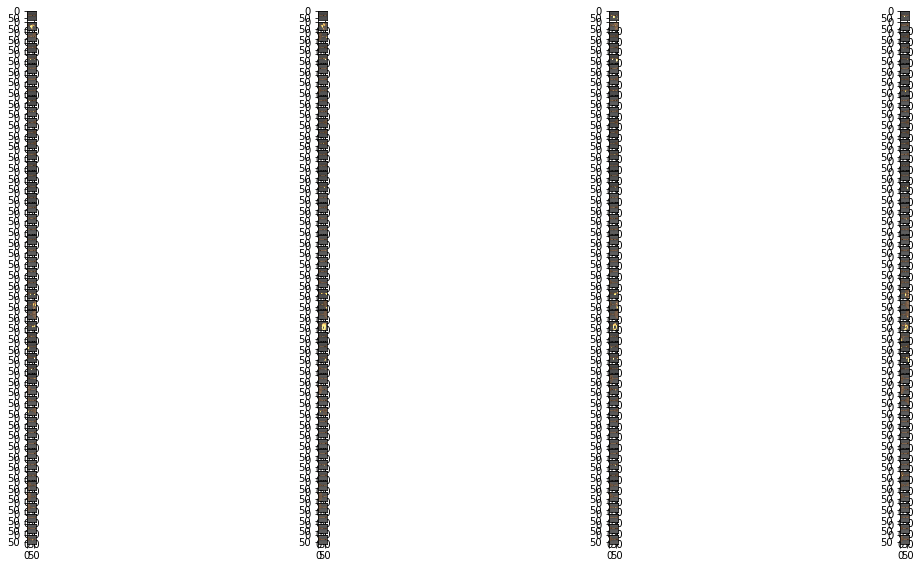

In [55]:
import pandas as pd
mixture_event_summaries = []
STATISTICAL_REPETITIONS = 20
SEQUENCE_LENGTH = 1000
num_mixtures = 4
model_to_analyze = rnn_analyzers[num_mixtures][0]
for rep in range(STATISTICAL_REPETITIONS):
    event_mixture_dict = count_events_in_each_mixture(model_to_analyze, num_mixtures, SEQUENCE_LENGTH)
    mixture_event_summaries.append(event_mixture_dict)
    
mixture_event_dataframe = pd.DataFrame(mixture_event_summaries)
print(mixture_event_dataframe)

In [56]:
#Transforming the dict to the kind of dataframe we want
mixture_summaries = []
potential_events = ["explosion", "fireball", "left_wall", "right_wall", "other"]
for current_measure in mixture_event_summaries:
    for num_mixtures, event_data in current_measure.items():
        for e in potential_events:
            entry = {"mixture_num" : event_data["mixture_num"], "event" : e, "observations":event_data[e]}
            mixture_summaries.append(entry)
        
print(mixture_summaries)
mixture_summaries=pd.DataFrame(mixture_summaries)

[{'mixture_num': 0, 'event': 'explosion', 'observations': 47}, {'mixture_num': 0, 'event': 'fireball', 'observations': 227}, {'mixture_num': 0, 'event': 'left_wall', 'observations': 7}, {'mixture_num': 0, 'event': 'right_wall', 'observations': 15}, {'mixture_num': 0, 'event': 'other', 'observations': 69}, {'mixture_num': 1, 'event': 'explosion', 'observations': 12}, {'mixture_num': 1, 'event': 'fireball', 'observations': 117}, {'mixture_num': 1, 'event': 'left_wall', 'observations': 1}, {'mixture_num': 1, 'event': 'right_wall', 'observations': 1}, {'mixture_num': 1, 'event': 'other', 'observations': 2}, {'mixture_num': 2, 'event': 'explosion', 'observations': 0}, {'mixture_num': 2, 'event': 'fireball', 'observations': 94}, {'mixture_num': 2, 'event': 'left_wall', 'observations': 20}, {'mixture_num': 2, 'event': 'right_wall', 'observations': 7}, {'mixture_num': 2, 'event': 'other', 'observations': 31}, {'mixture_num': 3, 'event': 'explosion', 'observations': 21}, {'mixture_num': 3, 'eve

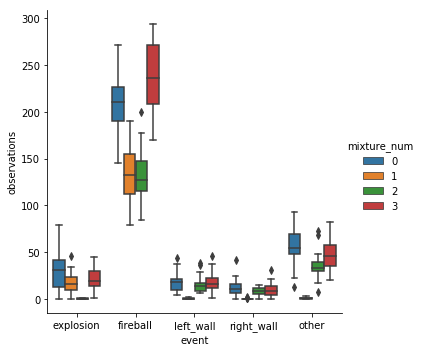

In [57]:
#print(mixture_summaries)
import seaborn as sns
sns.catplot(x="event", y="observations", kind="box", data=mixture_summaries, hue="mixture_num")

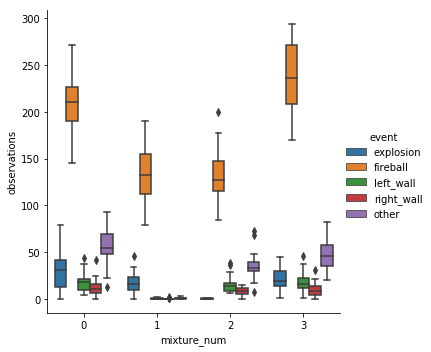

In [58]:
sns.catplot(x="mixture_num", y="observations", kind="box", data=mixture_summaries, hue="event")

In [20]:
def count_events_in_main_vs_other_mixtures(events_dataframe, event_name, main_mixture_summary, summary_num_events_dataframe):
    #Helps analyze if one mixture typically takes responsability
    #for analyzing one specific event.
    
    #Counting how often the event is present in the most common mixture,
    #vs all the others.
    event_in_main_mixture = events_dataframe[event_name+"_main"]
    event_in_other_mixtures = events_dataframe[event_name+"_other"]
    id_of_main_mixture = [d[event_name] for d in main_mixture_summary]
    
    total_num_main_mixture = []
    total_num_all_mixtures = []
    summary_num_events_dataframe=summary_num_events_dataframe.fillna(0)
    for index, row in summary_num_events_dataframe.iterrows():
        total_num_main_mixture.append(row[id_of_main_mixture[index]])
        total_num_all_mixtures.append(sum(row))

    total_non_main_mixture = np.subtract(np.array(total_num_all_mixtures), total_num_main_mixture)
    event_proportion_in_main=np.divide(event_in_main_mixture,np.add(event_in_other_mixtures,event_in_main_mixture))
    total_proportion_in_main=np.divide(total_num_main_mixture,total_num_all_mixtures)
                                
                                
    main_mixture_dict = {event_name: event_in_main_mixture,
                  "total" : total_num_main_mixture,
                        "main_mixture": "Yes"}
    non_main_mixture_dict = {event_name: event_in_other_mixtures,
                  "total": total_non_main_mixture,
                                "main_mixture":"No"}
    
    
    #Measures difference between: (Event modelled my MainMixture/TotalNumEvent) and
    #(total modelled by MainMixture/ totalAllEvents)
    main_model_proportion_dict_event = {event_name+"_proportion" : event_proportion_in_main, "event_only" :"Yes"}
    main_model_proportion_dict_total = {event_name+"_proportion": total_proportion_in_main, "event_only" : "No"}
    
    return_frame = pd.DataFrame(main_mixture_dict)
    return_frame_b = pd.DataFrame(non_main_mixture_dict)
    return_frame= return_frame.append(return_frame_b)
    
    main_model_proportion_frame = pd.DataFrame(main_model_proportion_dict_event)
    main_model_proportion_frame_b = pd.DataFrame(main_model_proportion_dict_total)
    main_model_proportion_frame = main_model_proportion_frame.append(main_model_proportion_frame_b)
    return return_frame, main_model_proportion_frame

In [21]:
from scipy.stats import mannwhitneyu

def significance_test(dataframe, event_name):
    #Does two tests of significance:
    #1. Are there significantly more occurences of event event_name
    #in the "main" mixture than in the others?
    #2. Are there significant differences between the number of total
    #events in the main mixture than others?
    #The latter controls for situations where all/very many events
    #end up being modelled by 1 mixture.
    main_mixture_data = dataframe.loc[dataframe['main_mixture'] == 'Yes']
    other_mixture_data = dataframe.loc[dataframe['main_mixture'] == 'No']
    event_main = main_mixture_data[event_name]
    total_main = main_mixture_data['total']
    event_other = other_mixture_data[event_name]
    total_other = other_mixture_data['total']
    
    print("Significant differences between number of the event in main vs all other mixtures")
    print("Significant differences between number of ANY event in main vs all other mixtures")

    print(mannwhitneyu(event_main, event_other, alternative='two-sided'))
    print(mannwhitneyu(total_main, total_other, alternative='two-sided'))

In [41]:
def significance_test_proportions_frame(proportions_frame):
    #Test if the "main mixture" is significantly more common for the
    #event∕situation than it is overall.
    event_only_proportion = proportions_frame.loc[proportions_frame['event_only'] == 'Yes']
    total_proportion = proportions_frame.loc[proportions_frame['event_only'] == 'No']
        
    print("Significant differences between proportion of the mixture in event vs in all frames")
    print(mannwhitneyu(event_only_proportion[event_only_proportion.columns[0]], total_proportion[total_proportion.columns[0]], alternative='two-sided'))

## Explosions

In [23]:
explosions_data, proportions_frame = count_events_in_main_vs_other_mixtures(events_dataframe, "explosion", main_mixture_summary, summary_num_events_dataframe)
print(explosions_data)
pd.melt(explosions_data, id_vars=['main_mixture'])

    explosion  total main_mixture
0          19    577          Yes
1          10    189          Yes
2         127    276          Yes
3           4    174          Yes
4         168    248          Yes
5         114    277          Yes
6         400    487          Yes
7         155    568          Yes
8          21    167          Yes
9          73    220          Yes
10         96    219          Yes
11         45    228          Yes
12        138    573          Yes
13         49    184          Yes
14         64    168          Yes
15        149    421          Yes
16         74    115          Yes
17          0     85          Yes
18         90    187          Yes
19          0    750          Yes
20         32    177          Yes
21        130    305          Yes
22        226    260          Yes
23         69    211          Yes
24         75    505          Yes
25         64    212          Yes
26         81    312          Yes
27        261    441          Yes
28         33 

/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


,main_mixture,variable,value
0,Yes,explosion,19
1,Yes,explosion,10
2,Yes,explosion,127
3,Yes,explosion,4
4,Yes,explosion,168
5,Yes,explosion,114
6,Yes,explosion,400
7,Yes,explosion,155
8,Yes,explosion,21
9,Yes,explosion,73


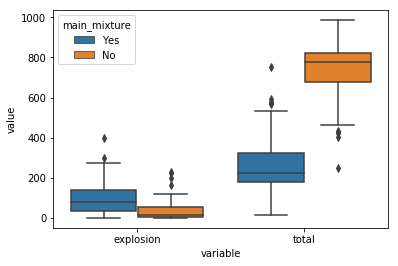

In [24]:
import seaborn as sns
sns.boxplot(x="variable", y="value", hue="main_mixture", data=pd.melt(explosions_data, id_vars=['main_mixture']))



In [25]:
significance_test(explosions_data, 'explosion')

Significant differences between number of the event in main vs all other mixtures
Significant differences between number of ANY event in main vs all other mixtures
MannwhitneyuResult(statistic=2639.5, pvalue=1.0572780502652836e-05)
MannwhitneyuResult(statistic=119.0, pvalue=1.1405280639276962e-18)


Significant differences between proportion of the mixture in event vs in all frames
MannwhitneyuResult(statistic=2943.0, pvalue=2.013482242406131e-09)
None


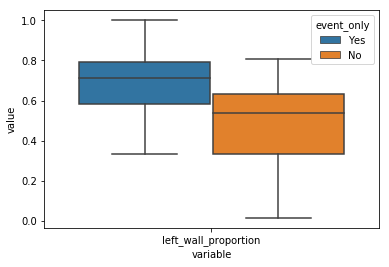

In [42]:
print(significance_test_proportions_frame(proportions_frame))
sns.boxplot(x="variable", y="value", hue="event_only", data=pd.melt(proportions_frame, id_vars=['event_only']))

## Left Walls

In [44]:
left_walls_data, proportions_frame = count_events_in_main_vs_other_mixtures(events_dataframe, "left_wall", main_mixture_summary, summary_num_events_dataframe)
significance_test(left_walls_data, "left_wall")
#Result: Left wall far more common in main mixture. However, the total
#distribution of this mixture is not significantly larger than others.
pd.melt(left_walls_data, id_vars=['main_mixture'])

Significant differences between number of the event in main vs all other mixtures
Significant differences between number of ANY event in main vs all other mixtures
MannwhitneyuResult(statistic=2618.5, pvalue=1.750598857121085e-05)
MannwhitneyuResult(statistic=1686.0, pvalue=0.5513564288171047)


/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


,main_mixture,variable,value
0,Yes,left_wall,113
1,Yes,left_wall,98
2,Yes,left_wall,111
3,Yes,left_wall,49
4,Yes,left_wall,22
5,Yes,left_wall,41
6,Yes,left_wall,17
7,Yes,left_wall,7
8,Yes,left_wall,5
9,Yes,left_wall,45


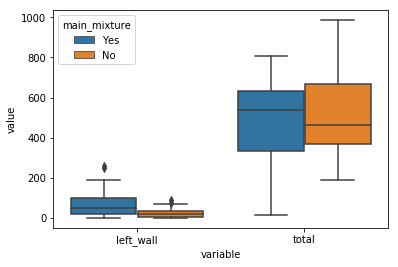

In [31]:
sns.boxplot(x="variable", y="value", hue="main_mixture", data=pd.melt(left_walls_data, id_vars=['main_mixture']))

Significant differences between proportion of the mixture in event vs in all frames
MannwhitneyuResult(statistic=2943.0, pvalue=2.013482242406131e-09)
None


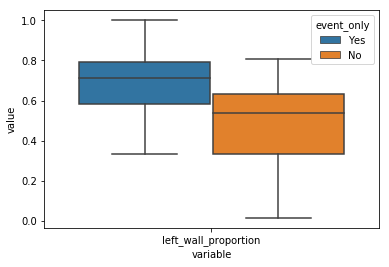

In [45]:
print(significance_test_proportions_frame(proportions_frame))
sns.boxplot(x="variable", y="value", hue="event_only", data=pd.melt(proportions_frame, id_vars=['event_only']))

## Right Walls

Significant differences between number of the event in main vs all other mixtures
Significant differences between number of ANY event in main vs all other mixtures
MannwhitneyuResult(statistic=2226.0, pvalue=0.02391217629842082)
MannwhitneyuResult(statistic=938.0, pvalue=6.133518159294231e-06)


/home/kaiolae/.virtualenvs/world_models_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


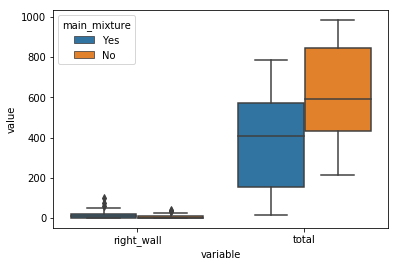

In [46]:
right_walls_data, proportions_frame = count_events_in_main_vs_other_mixtures(events_dataframe, "right_wall", main_mixture_summary, summary_num_events_dataframe)
significance_test(right_walls_data, "right_wall")
pd.melt(right_walls_data, id_vars=['main_mixture'])
sns.boxplot(x="variable", y="value", hue="main_mixture", data=pd.melt(right_walls_data, id_vars=['main_mixture']))

Significant differences between proportion of the mixture in event vs in all frames
MannwhitneyuResult(statistic=3168.5, pvalue=6.933062385866509e-13)
None


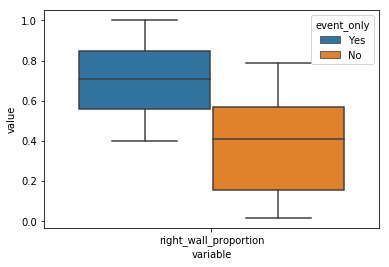

In [47]:
print(significance_test_proportions_frame(proportions_frame))
sns.boxplot(x="variable", y="value", hue="event_only", data=pd.melt(proportions_frame, id_vars=['event_only']))

## Fireballs

Significant differences between number of the event in main vs all other mixtures
Significant differences between number of ANY event in main vs all other mixtures
MannwhitneyuResult(statistic=2475.5, pvalue=0.00039559753785814976)
MannwhitneyuResult(statistic=2615.0, pvalue=1.9104690646102346e-05)


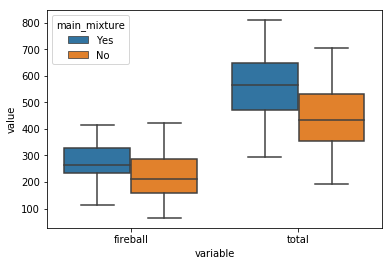

In [49]:
fireball_data, proportions_frame = count_events_in_main_vs_other_mixtures(events_dataframe, "fireball", main_mixture_summary, summary_num_events_dataframe)
significance_test(fireball_data, "fireball")
#Fireball more common in main mixture, but this mixture is so dominating
#that this is to be expected.
pd.melt(right_walls_data, id_vars=['main_mixture'])
sns.boxplot(x="variable", y="value", hue="main_mixture", data=pd.melt(fireball_data, id_vars=['main_mixture']))

Significant differences between proportion of the mixture in event vs in all frames
MannwhitneyuResult(statistic=1768.0, pvalue=0.8686818987976536)
None


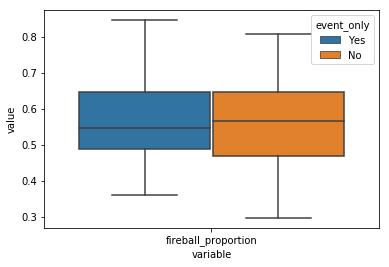

In [50]:
print(significance_test_proportions_frame(proportions_frame))
sns.boxplot(x="variable", y="value", hue="event_only", data=pd.melt(proportions_frame, id_vars=['event_only']))